In [1]:
#pip install python_speech_features==0.4

In [2]:
# Packages 
import os
import re
import random
import numpy as np
from python_speech_features import mfcc
from sklearn.mixture import GaussianMixture
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# train the GMM on the concatenated MFCC features
random.seed(0)

person_num = 3  # Index number of person to train on 
test_samples = 10  # Number of samples to test

paths = os.listdir('../data/recordings/')  # Filename of every recording 
random.shuffle(paths) # Shuffle data so test and train contain multiple different words  

# extracts all the people names in the dataset
people = list(set([" ".join(re.findall("[a-zA-Z]+", "".join(x.split('.')[0:-1]))) for x in paths]))
people.sort()

# add relative path
paths = ['../data/recordings/'+ x for x in paths]

print(f'Training on {people[person_num]}')
print(people)

Training on nicolas
['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']


In [4]:
# Testing with alternative larger and more interesting dataset

# directory containing the training data files
one_person_paths = [x for x in paths if people[person_num] in x]
train_paths = one_person_paths[0:-test_samples]  # Keep the first 490 samples for training
test_paths = one_person_paths[-test_samples:]  # Keep the last 10 samples for testing 

print(len(train_paths))
print(len(test_paths))
#print(test_paths)

490
10


In [5]:
# create a GMM with n components
n = 20
gmm = GaussianMixture(n_components=n)

# loop over each audio file in the data directory to extract features
mfcc_features = None  # Create empty dataframe
for file_path in train_paths:
    sample_rate, audio_data = wavfile.read(file_path)  # extract data and sample rate for each file
    
    # compute MFCC features for the audio data
    mfcc_data = mfcc(audio_data, sample_rate)
    
    # concatenate the MFCC features into a single numpy array
    if mfcc_features is None:
        mfcc_features = mfcc_data
    else:
        mfcc_features = np.concatenate((mfcc_features, mfcc_data), axis=0)

In [6]:
print(mfcc_features[0])

[ 18.28724711   0.10534504 -20.11034637 -46.68443102  -5.85794963
   3.57784646  -6.55325388 -15.80200711 -14.58062069  -3.6266417
  -8.03280999 -12.3525111    4.68319853]


In [7]:
# train the GMM on the concatenated MFCC features
gmm.fit(mfcc_features)

GaussianMixture(n_components=20)

In [8]:
# Calculate scores for Imposter recordings

imposter_scores = []

for person in people:
    if person != people[person_num]:  # If person was not trained on get a random sample of 10 recordings for testing  
        person_paths = random.sample([x for x in paths if person in x], test_samples)
    else: 
        continue
        
    individual_scores = [] 
    for path in person_paths:
        sample_rate, test_data = wavfile.read(path)  # Extract data
        mfcc_data = mfcc(test_data, sample_rate, numcep=13)  # Feature extraction
        score = gmm.score(mfcc_data) # Calulate score
        individual_scores.append(score)   # Get classification score for each recording
    
    imposter_scores.extend(individual_scores) 

print(len(imposter_scores))

50


In [9]:
# Calculate scores for genuine recordings 

genuine_scores = []

for path in test_paths:
    sample_rate, test_data = wavfile.read(path)  # Extract data
    mfcc_data = mfcc(test_data, sample_rate, numcep=13)  # Feature extraction
    score = gmm.score(mfcc_data) # Calulate score
    genuine_scores.append(score)   # Get classification score for each recording
    
print(len(genuine_scores))

10


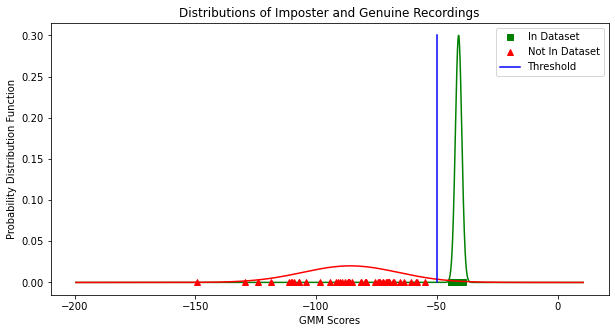

In [10]:
# Plot genuine and imposter distributions to determine a threshold

person_scores = list(genuine_scores)
person_scores.extend(imposter_scores) 

lowest_value = min(person_scores)
highest_value = max(person_scores)

x = np.arange(lowest_value-50, highest_value+50, 0.01)

genuine = norm.pdf(x, loc=np.mean(genuine_scores), scale=np.std(genuine_scores))
imposter = norm.pdf(x, loc=np.mean(imposter_scores), scale=np.std(imposter_scores))

threshold = -50

plt.figure(figsize=(10,5))
plt.plot(x, genuine, 'g')
plt.plot(genuine_scores, np.zeros(len(genuine_scores)), 'gs', lw=2, label='In Dataset')
plt.plot(x, imposter, 'r')
plt.plot(imposter_scores, np.zeros(len(imposter_scores)), 'r^', lw=2, label='Not In Dataset')
plt.plot([threshold]*20, np.linspace(0, 0.3, 20), 'b', label='Threshold')
plt.xlabel("GMM Scores")
plt.ylabel("Probability Distribution Function")
plt.legend();
plt.title('Distributions of Imposter and Genuine Recordings');

plt.show()

True Rejection Rate :100.0
False Accecptance Rate :0.0
False Rejection Rate :0.0
True Accecptance Rate :100.0


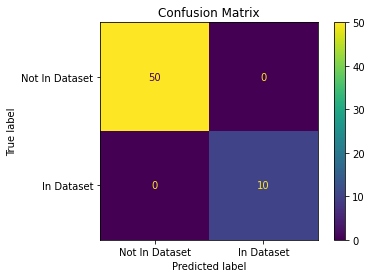

In [11]:
# Choose threshold and make confusion matrix 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

TA = 0
FA = 0
TR = 0
FR = 0

for score in genuine_scores:
    if score < threshold:
        FR = FR + 1
    else:
        TA = TA + 1

for score in imposter_scores:
    if score < threshold: 
        TR = TR + 1
    else:
        FA = FA + 1
        
Total = len(genuine_scores) + len(imposter_scores)

print("True Rejection Rate :" + str((TR/(TR+FA))*100))
print("False Accecptance Rate :" + str((FA/(FA+TR))*100))
print("False Rejection Rate :" + str((FR/(FR+TA))*100))
print("True Accecptance Rate :" + str((TA/(TA+FR))*100))

cm = np.array([[TR, FA], [FR, TA]])
labels = np.array(["Not In Dataset", "In Dataset"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title('Confusion Matrix');
plt.show()